In [108]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

import numpy as np
import xgboost as xgb

import sys
import os
sys.path.append(os.path.abspath(".."))
from nfl_prediction.modeling.train import scale_vegas_features, select_features
from loguru import logger

def report_split(X_split, y_split, win_split):
    predictions = model.predict(X_split)
    mae = mean_absolute_error(y_split, predictions)
    rmse = root_mean_squared_error(y_split, predictions)
    r2 = r2_score(y_split, predictions)
    
    pred_win = (predictions > 0).astype(int)
    win_acc = (pred_win == win_split).mean()
    
    logger.info(
        f"MAE={mae:.3f} | RMSE={rmse:.3f} | R2={r2:.3f} | WIN ACCURACY={win_acc:.3f}"
    )
    return mae, rmse, r2, win_acc

df = pd.read_csv("/Users/ryansteele/my_repo2/data/processed/matchups/matchups_all_seasons.csv")

target = "point_diff"
df = df.dropna(subset=[target])

df = scale_vegas_features(df)
feature_cols = select_features(df, target)
df[feature_cols] = df[feature_cols].fillna(0)

X = df[feature_cols]
y = df[target]

df["next_game_win"] = (df[target] > 0).astype(int)
win = df["next_game_win"]

#train_week = 12
#test_week = 13
train_weeks = list(range(1, 14))
maes = []
rmse = []
r2 = []
win_acc = []
beat_vegas_mean = []
avg_edge = []
ats_acc = []

profitable_weeks = 0

bias_list = []

for week in train_weeks:
    train_week = week
    test_week = week + 1
    train_split = (
        ((df["season"] >= 2024) & (df["season"] <= 2024)) |
        ((df["season"] == 2025) & (df["week"] <= train_week))
    )

    test_split = (df["season"] == 2025) & (df["week"] == test_week)

    X_train, y_train = X[train_split], y[train_split]
    X_test, y_test = X[test_split], y[test_split]

    win_train = win[train_split]
    win_test = win[test_split]

    model = xgb.XGBRegressor(
        objective="reg:squarederror",
        n_estimators=600,
        learning_rate=0.05,
        eval_metric="mae",
        random_state=34,
        n_jobs=1,
        # **best_params,
        max_depth=1,
        min_child_weight=14,
        subsample=0.9,
        colsample_bytree=0.6,
        reg_lambda=3.0,
        reg_alpha=0.0,
    )

    model.fit(
        X_train,
        y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=False
    )

    print(f"\nTrain 2022 thru 2025 week {train_week}:\n")
    report_split(X_train, y_train, win_train)
    print(f"\nTest 2025 week {test_week}:\n")
    mae_test, rmse_test, r2_test, winacc_test = report_split(X_test,  y_test,  win_test)

    preds_test = model.predict(X_test)
    if len(bias_list) > 0:
        bias = np.mean(bias_list)/2
        #preds_test = preds_test - bias

    model_err = preds_test - y_test
    spread_mae = np.mean(np.abs(model_err))
    spread_bias = np.mean(model_err)

    if "vegas_spread_raw" in df.columns:
        vegas_spread_raw = df.loc[test_split, "vegas_spread_raw"].values
        vegas_err = (- vegas_spread_raw) - y_test.values

        # 1) Beat-Vegas rate
        model_abs = np.abs(model_err)
        vegas_abs = np.abs(vegas_err)
        beat_vegas = (model_abs < vegas_abs)
        beat_vegas_rate = beat_vegas.mean()

        # 2) Average edge vs Vegas (negative = better than Vegas)
        avg_edge_vs_vegas = float(np.mean(model_abs - vegas_abs))

        # 3) ATS accuracy (model vs actual cover)
        # Home covers if actual margin > -spread
        home_covers_actual = (y_test.values > -vegas_spread_raw).astype(int)
        home_covers_model  = (preds_test > -vegas_spread_raw).astype(int)
        ats_acc_model = (home_covers_actual == home_covers_model).mean()

        logger.info(
            f"[Season 2025] Beat-Vegas rate: {beat_vegas_rate:.3f} | "
            f"Avg edge vs Vegas (MAE diff): {avg_edge_vs_vegas:.3f} | "
            f"ATS accuracy (model): {ats_acc_model:.3f}"
        )
    else:
        beat_vegas_rate = np.nan
        avg_edge_vs_vegas = np.nan
        ats_acc_model = np.nan
    
    bias_list.append(np.mean(preds_test - y_test))
    

    maes.append(mae_test)
    rmse.append(rmse_test)
    r2.append(r2_test)
    win_acc.append(winacc_test)
    beat_vegas_mean.append(beat_vegas_rate)
    avg_edge.append(avg_edge_vs_vegas)
    ats_acc.append(ats_acc_model)
    
    if ats_acc_model >= 0.55:
        profitable_weeks += 1

    logger.info(f"[Season 2025] Test Spread MAE: {spread_mae:.3f}")
    logger.info(f"[Season 2025] Spread Bias (positive = overpredicting home): {spread_bias:.3f}\n")

print("""\nEval Metric Averages:
      For each week w,
      - train on 2022-2025 week w
      - test on week w + 1
      """)
print(f"Profitable Weeks: {profitable_weeks}/{len(train_weeks)}")
print(f"\nMean MAE: {np.mean(maes)}")
print(f"Mean RMSE: {np.mean(rmse)}")
print(f"Mean R2: {np.mean(r2)}")
print(f"Mean Win Acc: {np.mean(win_acc)}")

print(f"\nMean Beat Vegas Rate: {np.mean(beat_vegas_mean)}")
print(f"Best Beat Vegas Rate: {max(beat_vegas_mean)}")
print(f"Worst Beat Vegas Rate: {min(beat_vegas_mean)}")

print(f"\nMean Edge vs Vegas: {np.mean(avg_edge)}")
print(f"Best Edge vs Vegas: {min(avg_edge)}")
print(f"Worst Edge vs Vegas: {max(avg_edge)}")

print(f"\nMean ATS Acc (model): {np.mean(ats_acc)}")
print(f"Best ATS Acc (model): {max(ats_acc)}")
print(f"Worst ATS Acc (model): {min(ats_acc)}")


Train 2022 thru 2025 week 1:

2025-12-11 19:30:10.609 | INFO     | __main__:report_split:22 - MAE=7.105 | RMSE=9.012 | R2=0.597 | WIN ACCURACY=0.788

Test 2025 week 2:

2025-12-11 19:30:10.610 | INFO     | __main__:report_split:22 - MAE=8.319 | RMSE=11.326 | R2=0.292 | WIN ACCURACY=0.625
2025-12-11 19:30:10.611 | INFO     | __main__:<module>:129 - [Season 2025] Beat-Vegas rate: 0.500 | Avg edge vs Vegas (MAE diff): 0.069 | ATS accuracy (model): 0.562
2025-12-11 19:30:10.611 | INFO     | __main__:<module>:153 - [Season 2025] Test Spread MAE: 8.319
2025-12-11 19:30:10.611 | INFO     | __main__:<module>:154 - [Season 2025] Spread Bias (positive = overpredicting home): 3.483


Train 2022 thru 2025 week 2:

2025-12-11 19:30:10.711 | INFO     | __main__:report_split:22 - MAE=7.090 | RMSE=9.070 | R2=0.590 | WIN ACCURACY=0.793

Test 2025 week 3:

2025-12-11 19:30:10.712 | INFO     | __main__:report_split:22 - MAE=13.915 | RMSE=17.891 | R2=-0.290 | WIN ACCURACY=0.625
2025-12-11 19:30:10.713 | 

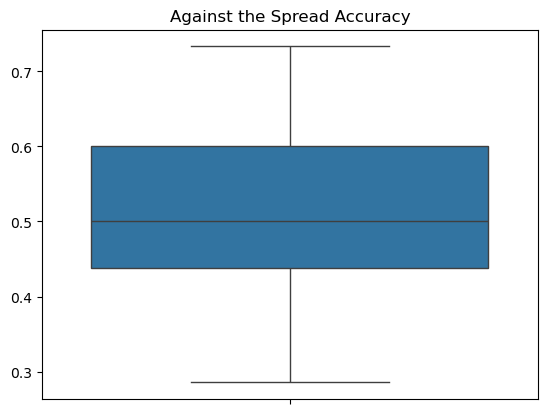

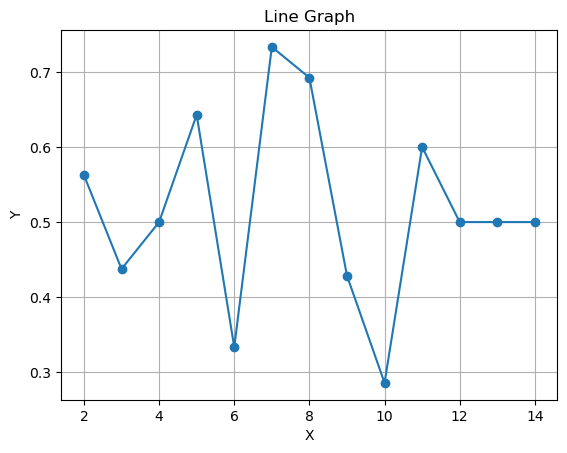

In [110]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(data=ats_acc)
plt.title("Against the Spread Accuracy")
plt.show()

x = range(2, 15)
y = ats_acc

plt.plot(x, y, marker='o')   # marker='o' shows the points
plt.title("Line Graph")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)
plt.show()